In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import copy
import time

In [2]:
torch.manual_seed(10)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

In [3]:
device

device(type='mps')

In [4]:
mean = np.array([0.4914, 0.4822, 0.4465])
std_dev = np.array([0.2023, 0.1994, 0.2010])

In [5]:
transform1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])
# transform2 = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.RandomRotation(degrees=(-20, 20)),
#     transforms.RandomPerspective(distortion_scale=0.3, p=1.5),
#     transforms.ToTensor(),
#     transforms.Normalize(mean,std_dev)
# ])
# transform3 = transforms.Compose([
#     transforms.Resize((224,224)),
#     transforms.AugMix(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean,std_dev)
# ])
transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std_dev)
])

In [6]:
train_data = torchvision.datasets.CIFAR10(
    root='../datasets',
    train = True,
    transform=transform1 #download is False in default
)
# train_data2 = torchvision.datasets.MNIST(
#     root='../datasets',
#     train = True,
#     transform=transform2 #download is False in default
# )
# train_data3 = torchvision.datasets.MNIST(
#     root='../datasets',
#     train = True,
#     transform=transform3 #download is False in default
# )

test_data = torchvision.datasets.MNIST(
    root='../datasets',
    train = False,
    transform=transform_test
)

In [7]:
# train_data = train_data.__add__(train_data2)
# train_data = train_data.__add__(train_data3)

In [8]:
len(train_data)

50000

In [9]:
num_epochs = 50
batch_size = 128
learning_rate = 1e-3

In [10]:
train_loader = torch.utils.data.DataLoader(
    dataset = train_data,
    batch_size = batch_size,
    shuffle = True
)
test_loader = torch.utils.data.DataLoader(
    dataset = test_data,
    batch_size = batch_size,
    shuffle = True
)

In [11]:
len(train_loader)

391

In [12]:
def imshow(img):
    img = img * np.average(std_dev) + np.average(mean)  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # Transpose along the axes (1,2,0)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


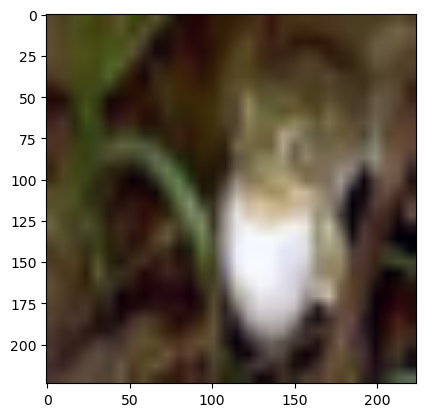

In [13]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(images[2])

In [14]:
images.shape

torch.Size([128, 3, 224, 224])

In [15]:
class myResNet18(nn.Module):
    def __init__(self):
        super(myResNet18, self).__init__()

        self.conv1 = nn.Conv2d(3,64,5,2,2) # 64, 112, 112
        self.norm1 = nn.BatchNorm2d(64)

        self.pool1 = nn.MaxPool2d(3,2,1) # 64, 56, 56

        self.conv2_1 = nn.Conv2d(64,64,3,1,'same') # 64, 56, 56
        self.conv2_2 = nn.Conv2d(64,64,3,1,'same') # 64, 56, 56
        self.conv2_3 = nn.Conv2d(64,64,3,1,'same') # 64, 56, 56
        self.conv2_4 = nn.Conv2d(64,64,3,1,'same') # 64, 56, 56
        self.conv1to2_1 = nn.Conv2d(3,64,5,2,2) # 64, 56, 56
        self.conv1to2_2 = nn.Conv2d(3,64,5,2,2) # 64, 56, 56
        self.conv1to2_3 = nn.Conv2d(3,64,5,2,2) # 64, 56, 56
        self.conv1to2_4 = nn.Conv2d(3,64,5,2,2) # 64, 56, 56
        self.norm2_1 = nn.BatchNorm2d(64)
        self.norm2_2 = nn.BatchNorm2d(64)
        self.norm2_3 = nn.BatchNorm2d(64)
        self.norm2_4 = nn.BatchNorm2d(64)
        self.maxpool1to2 = nn.MaxPool2d(2,2)


        self.conv3_1 = nn.Conv2d(64,128,3,2,1) # 128, 28, 28
        self.conv3_2 = nn.Conv2d(128,128,3,1,'same') # 128, 28, 28
        self.conv3_3 = nn.Conv2d(128,128,3,1,'same') # 128, 28, 28
        self.conv3_4 = nn.Conv2d(128,128,3,1,'same') # 128, 28, 28
        self.conv1to3_1 = nn.Conv2d(3,128,5,2,2) # 128, 112, 112
        self.conv1to3_2 = nn.Conv2d(3,128,5,2,2) # 128, 28, 28
        self.conv1to3_3 = nn.Conv2d(3,128,5,2,2) # 128, 28, 28
        self.conv1to3_4 = nn.Conv2d(3,128,5,2,2) # 128, 28, 28
        self.norm3_1 = nn.BatchNorm2d(128)
        self.norm3_2 = nn.BatchNorm2d(128)
        self.norm3_3 = nn.BatchNorm2d(128)
        self.norm3_4 = nn.BatchNorm2d(128)
        self.avgpool1to3 = nn.AvgPool2d(4,4)


        self.conv4_1 = nn.Conv2d(128,256,3,2,1) # 256, 14, 14
        self.conv4_2 = nn.Conv2d(256,256,3,1,'same') # 256, 14, 14
        self.conv4_3 = nn.Conv2d(256,256,3,1,'same') # 256, 14, 14
        self.conv4_4 = nn.Conv2d(256,256,3,1,'same') # 256, 14, 14
        self.conv1to4_1 = nn.Conv2d(3,256,5,2,2) # 256, 14, 14
        self.conv1to4_2 = nn.Conv2d(3,256,5,2,2) # 256, 14, 14
        self.conv1to4_3 = nn.Conv2d(3,256,5,2,2) # 256, 14, 14
        self.conv1to4_4 = nn.Conv2d(3,256,5,2,2) # 256, 14, 14
        self.avgpool1to4 = nn.AvgPool2d(8,8)
        self.norm4_1 = nn.BatchNorm2d(256)
        self.norm4_2 = nn.BatchNorm2d(256)
        self.norm4_3 = nn.BatchNorm2d(256)
        self.norm4_4 = nn.BatchNorm2d(256)


        self.conv5_1 = nn.Conv2d(256,512,3,2,1) # 512, 7, 7
        self.conv5_2 = nn.Conv2d(512,512,3,1,'same') # 512, 7, 7
        self.conv5_3 = nn.Conv2d(512,512,3,1,'same') # 512, 7, 7
        self.conv5_4 = nn.Conv2d(512,512,3,1,'same') # 512, 7, 7
        self.conv1to5_1 = nn.Conv2d(3,512,5,2,2) # 512, 7, 7
        self.conv1to5_2 = nn.Conv2d(3,512,5,2,2) # 512, 7, 7
        self.conv1to5_3 = nn.Conv2d(3,512,5,2,2) # 512, 7, 7
        self.conv1to5_4 = nn.Conv2d(3,512,5,2,2) # 512, 7, 7
        self.avgpool1to5 = nn.AvgPool2d(16,16)
        self.norm5_1 = nn.BatchNorm2d(512)
        self.norm5_2 = nn.BatchNorm2d(512)
        self.norm5_3 = nn.BatchNorm2d(512)
        self.norm5_4 = nn.BatchNorm2d(512)

        self.pool2 = nn.AvgPool2d(2,2) # 512, 3, 3
        

        self.flatten = nn.Flatten()

        self.lin5 = nn.Linear(512*3*3, 1000)
        self.conv_flatten = nn.Conv2d(3,1,5,2,2)
        self.avgpool5 = nn.AvgPool2d(2,2)
        self.lin1to5 = nn.Linear(56*56*1, 1000)
        # self.act4 = nn.ReLU()
        self.norm5 = nn.BatchNorm1d(1000)

        self.lin_fin = nn.Linear(1000,10)
    
    def forward(self, x):
        x_temp1 = x
        x = self.norm1(torch.relu(self.conv1(x)))
        x = self.pool1(x)

        x = self.norm2_1(torch.relu(self.conv2_1(x)+self.maxpool1to2(self.conv1to2_1(x_temp1)))) # Residual
        x = self.norm2_2(torch.relu(self.conv2_2(x)+self.maxpool1to2(self.conv1to2_2(x_temp1)))) # Residual
        x = self.norm2_3(torch.relu(self.conv2_3(x)+self.maxpool1to2(self.conv1to2_3(x_temp1)))) # Residual
        x = self.norm2_4(torch.relu(self.conv2_4(x)+self.maxpool1to2(self.conv1to2_4(x_temp1)))) # Residual

        x = self.norm3_1(torch.relu(self.conv3_1(x)+self.avgpool1to3(self.conv1to3_1(x_temp1)))) # Residual
        x = self.norm3_2(torch.relu(self.conv3_2(x)+self.avgpool1to3(self.conv1to3_2(x_temp1)))) # Residual
        x = self.norm3_3(torch.relu(self.conv3_3(x)+self.avgpool1to3(self.conv1to3_3(x_temp1)))) # Residual
        x = self.norm3_4(torch.relu(self.conv3_4(x)+self.avgpool1to3(self.conv1to3_4(x_temp1)))) # Residual

        x = self.norm4_1(torch.relu(self.conv4_1(x)+self.avgpool1to4(self.conv1to4_1(x_temp1)))) # Residual
        x = self.norm4_2(torch.relu(self.conv4_2(x)+self.avgpool1to4(self.conv1to4_2(x_temp1)))) # Residual
        x = self.norm4_3(torch.relu(self.conv4_3(x)+self.avgpool1to4(self.conv1to4_3(x_temp1)))) # Residual
        x = self.norm4_4(torch.relu(self.conv4_4(x)+self.avgpool1to4(self.conv1to4_4(x_temp1)))) # Residual

        x = self.norm5_1(torch.relu(self.conv5_1(x)+self.avgpool1to5(self.conv1to5_1(x_temp1)))) # Residual
        x = self.norm5_2(torch.relu(self.conv5_2(x)+self.avgpool1to5(self.conv1to5_2(x_temp1)))) # Residual
        x = self.norm5_3(torch.relu(self.conv5_3(x)+self.avgpool1to5(self.conv1to5_3(x_temp1)))) # Residual
        x = self.norm5_4(torch.relu(self.conv5_4(x)+self.avgpool1to5(self.conv1to5_4(x_temp1)))) # Residual

        x = self.pool2(x)
        x = self.flatten(x)

        x = self.norm5(torch.relu(self.lin5(x)+self.lin1to5(self.flatten(self.avgpool5(self.conv_flatten(x_temp1))))))
        x = self.lin_fin(x)
        return(x)

In [16]:
resnet = myResNet18().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.5)

In [18]:
summary(copy.deepcopy(resnet).to('cpu'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           4,864
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         MaxPool2d-3           [-1, 64, 56, 56]               0
            Conv2d-4           [-1, 64, 56, 56]          36,928
            Conv2d-5         [-1, 64, 112, 112]           4,864
         MaxPool2d-6           [-1, 64, 56, 56]               0
       BatchNorm2d-7           [-1, 64, 56, 56]             128
            Conv2d-8           [-1, 64, 56, 56]          36,928
            Conv2d-9         [-1, 64, 112, 112]           4,864
        MaxPool2d-10           [-1, 64, 56, 56]               0
      BatchNorm2d-11           [-1, 64, 56, 56]             128
           Conv2d-12           [-1, 64, 56, 56]          36,928
           Conv2d-13         [-1, 64, 112, 112]           4,864
        MaxPool2d-14           [-1, 64,

In [20]:
best_weights = copy.deepcopy(resnet.state_dict())
max = 0
val_acc = 0
train_acc = 0
tic = time.time()
for epoch in range(num_epochs):
    resnet.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        preds = resnet.forward(images)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    scheduler.step() # Decaying learning rate per 25 epochs by 0.2 times
    print(f'Epoch {epoch+1}/{num_epochs}; Loss = {loss.item():.6f}; LR = {scheduler.get_last_lr()}')
    with torch.no_grad():
        n_samples = 0
        n_correct = 0
        resnet.eval()
        for images, labels in test_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        val_acc = n_correct/n_samples * 100

        if (max <= (n_correct/n_samples * 100)):
            print('SAVED MODEL WEIGHTS')
            max = val_acc
            best_weights = copy.deepcopy(resnet.state_dict())

        n_samples = 0
        n_correct = 0
        
        for images, labels in train_loader:
            images = images.to(device) # From 128, 1, 28, 28 ---> 128, 784
            labels = labels.to(device)
            pred_outputs1 = resnet(images)
            _, actual_preds1 = torch.max(pred_outputs1, 1) # Returns value, index
            n_samples += labels.shape[0]
            n_correct += (actual_preds1 == labels).sum().item()
        train_acc = n_correct/n_samples * 100
    
    print(f'Train Accuracy: {train_acc:.2f}%')
    print(f'Dev Accuracy: {val_acc:.2f}%')
    print("-"*20)
print('Finished Training!')
print(f'Best Test Accuracy = {max}%')
print(f'Time Taken = {(time.time()-tic)//60}m {(time.time()-tic)%60}s')

0


KeyboardInterrupt: 

In [23]:
resnet.load_state_dict(best_weights)
torch.save(resnet, 'models/SC_resnet18_cifar10.pt')